# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# Starbucks offers

In this project we will take a look at Starbucks' offers and what type of offers each type of customer prefers

# Q1 what is offer in general customers Prefer?
# Q2 Does preference for offers differ according to gender? Which gender prefers offers more?
# Q3 Does preference for offers differ according to income? 

In [50]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [ ]:
def plot_bar(data):
    """
    Plot a bar chart for offer completion percentage.

    Parameters:
        data (DataFrame): The data to be plotted, expected to be in DataFrame format.

    Returns:
        None
    """
    data.plot(kind='bar')
    plt.title('Offer Completion Percentage')
    plt.xlabel('Offer Type')
    plt.ylabel('Completion Percentage')
    plt.show()

In [ ]:
def plot_stack (data,category):

    """
    Plot stacked bar chart for data categorized by a given category.

    Parameters:
        data (DataFrame): The data to be plotted, expected to be in DataFrame format.
        category (str): The category by which the data will be categorized.

    Returns:
        None
    """
    # Plot the data
    data.unstack().plot(kind='bar')
    plt.title(category+' Offer Completion Percentage')
    plt.xlabel(category)
    plt.ylabel('Completion Percentage')
    plt.legend(title='Offer Type')
    plt.show()

# Data Understanding

In [51]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [52]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [53]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Data Processing and Cleaning

In [3]:
# new column 'ids', where each id string is replaced by an alphabetical ID
unique_offer = portfolio['id'].unique()
offer_to_id = {email: chr(ord('A') + idx) for idx, email in enumerate(unique_offer)}
portfolio['ids'] = portfolio['id'].map(offer_to_id)

# new column 'duration_h' duration in hours
portfolio['duration_h'] = portfolio['duration'] *24

# Drop columns
portfolio = portfolio.drop(columns=['id'])

# Reassign DataFrame with desired column order
portfolio = portfolio[['channels','difficulty','duration','duration_h','ids', 'offer_type','reward']]

In [5]:
# new column 'ids', where each id string is replaced by an integer ID
unique_id = profile['id'].unique()
id_to_ids = {id: idx for idx, id in enumerate(unique_id)}
profile['ids'] = profile['id'].map(id_to_ids)

# Drop columns
profile = profile.drop(columns=['id'])

# Reassign DataFrame with desired column order
profile = profile[['age','became_member_on','gender','ids','income']]

In [6]:
profile.tail()

,age,became_member_on,gender,ids,income
16995,45,20180604,F,16995,54000.0
16996,61,20180713,M,16996,72000.0
16997,49,20170126,M,16997,73000.0
16998,83,20160307,F,16998,50000.0
16999,62,20170722,F,16999,82000.0


In [7]:
# Extract dic value into new column
transcript['value_in'] = transcript['value'].apply(lambda x: x[list(x.keys())[0]])
# new column 'ids', where each id string is replaced by an alphabetical ID

# map offer string id  into alphabetical id
transcript.loc[transcript['event'] != 'transaction', 'value_in'] = transcript.loc[transcript['event'] != 'transaction', 'value_in'].map(offer_to_id)

# new column 'person_id', where each person string is replaced by an integer ID
transcript['person_id'] = transcript['person'].map(id_to_ids)

# Drop columns
transcript = transcript.drop(columns=['person','value'])

### we want to create new data  with new column 'complet'  front each offer received put 1 if completed and 0 if not completed 

In [ ]:
# new df TRC (transcript received complet)
TRC = transcript[transcript['event'].isin(['offer received','offer completed'])]
TRC['complet'] = np.nan

In [10]:
# merge TRC with portfolio to get 'duration_h' column
TRC=pd.merge(TRC, portfolio[['duration_h','offer_type','ids']], left_on='value_in', right_on='ids', how='left')
TRC.drop(columns=['ids'], inplace=True)

In [11]:
# new column 'time_end'
cond = (TRC['event'] == 'offer received') # condition
TRC.loc[cond, 'time_end'] = TRC.loc[cond, 'time']+TRC.loc[cond, 'duration_h']

### loop throw each offer received event for each person and put 1 if offer completed and 0 if not completed

### <font color='red'> Warning </p>: The code may take more than 40 minutes to save time loading data from the next cell after it

In [ ]:
person_list=TRC['person_id'].unique().tolist()
for index, person in enumerate(person_list):
    if index % 1700 == 0:
        print(f"{index / len(person_list) * 100:.2f}%")
    df_hhh =TRC[TRC['person_id']==person]
    df_received = df_hhh[df_hhh['event']=='offer received']
    df_completed = df_hhh[df_hhh['event']=='offer completed']
    for i in range(df_received.shape[0]):
        offer_id = df_received.iloc[i]['value_in']
        offer_start = df_received.iloc[i]['time']
        offer_end = df_received.iloc[i]['time_end']
        cond = ((df_completed['value_in']==offer_id)&(df_completed['time']<=offer_end) &(df_completed['time']>=offer_start))
        check = df_completed[cond]

        event = 'offer received'
        cond = ((TRC['person_id']==person) & (TRC['event']==event)&(TRC['value_in']==offer_id) & (TRC['time']==offer_start))
        if len(check)>0:
            TRC.loc[cond, 'complet'] = 1

        else:
            TRC.loc[cond, 'complet'] = 0

        
    

In [ ]:
#transcript_received_complet=TRC
#transcript_received_complet.to_csv('TRC.csv', index=False)

In [13]:
transcript_received_complet = pd.read_csv('TRC.csv')

In [14]:
TRC = transcript_received_complet

In [16]:
# new data fream TR 
TR = TRC[TRC['event']=='offer received']

#### Due to the data range time, some offers were received and the range time expired before the validity period expiry, let's fix that

In [17]:
max_time = transcript['time'].max()
TR = TR[~((TR['time']>(max_time - TR['duration_h']))& (TR['complet']==0 ))]

In [18]:
TR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71560 entries, 0 to 102054
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   event       71560 non-null  object 
 1   time        71560 non-null  int64  
 2   value_in    71560 non-null  object 
 3   person_id   71560 non-null  int64  
 4   complet     71560 non-null  float64
 5   duration_h  71560 non-null  int64  
 6   offer_type  71560 non-null  object 
 7   time_end    71560 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 4.9+ MB


In [19]:
new_data =pd.merge(TR, profile, left_on='person_id', right_on='ids', how='inner')
new_data.drop(columns=['ids','became_member_on','event','time','duration_h','time_end','person_id'], inplace=True)
new_data = new_data.dropna()

In [20]:
# Rename the 'value_in' column to 'offer'
new_data = new_data.rename(columns={'value_in': 'offer'})

#### for purpose of analysis we need to categorize income

In [21]:
low_income_threshold = new_data['income'].quantile(0.2)
high_income_threshold = new_data['income'].quantile(0.8)

# Categorize income
def categorize_income(income):
    if income < low_income_threshold:
        return 'Low'
    elif income < high_income_threshold:
        return 'Medium'
    else:
        return 'High'

# Apply categorization function to the 'Income' column
new_data['income_category'] = new_data['income'].apply(categorize_income)


#### informational offer does not really offer because that we drop it and drop other because it is low

In [22]:
# drop informational offer
new_data = new_data[~(new_data['offer_type']=='informational')]
new_data = new_data[~(new_data['gender']=='O')]

In [23]:
new_data.head()

,offer,complet,offer_type,age,gender,income,income_category
0,D,1.0,bogo,75,F,100000.0,High
2,A,1.0,bogo,75,F,100000.0,High
3,I,1.0,bogo,75,F,100000.0,High
7,J,0.0,discount,68,M,70000.0,Medium
9,D,1.0,bogo,68,M,70000.0,Medium


# Evaluate

## Q1 what is offer in general customers Prefer?

In [54]:
offer_percent= new_data.groupby(['offer_type'])['complet'].sum()/new_data.groupby(['offer_type'])['complet'].count()
offer_percent

offer_type
bogo        0.595164
discount    0.715871
Name: complet, dtype: float64

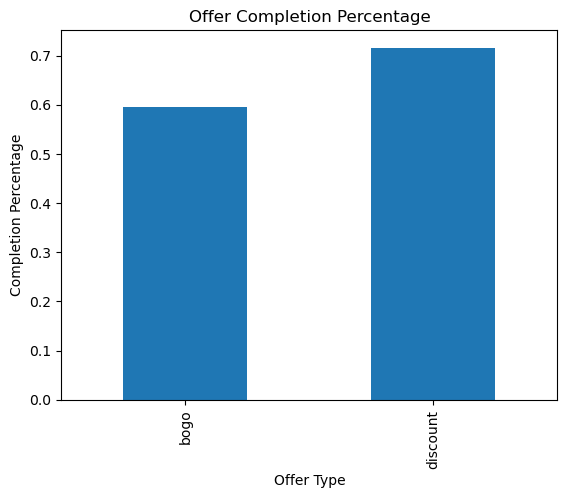

In [46]:
plot_bar(offer_percent)

Customers seem to prefer the discount offer more than the BOGO (buy one get one free) offer.

## Q2 Does preference for offers differ according to gender? Which gender prefers offers more?

In [55]:
gender_offer_percent = new_data.groupby(['gender', 'offer_type'])['complet'].sum()/new_data.groupby(['gender', 'offer_type'])['complet'].count()
gender_offer_percent

gender  offer_type
F       bogo          0.701553
        discount      0.792241
M       bogo          0.516893
        discount      0.659348
Name: complet, dtype: float64

Female seem to prefer the discount offer more than male

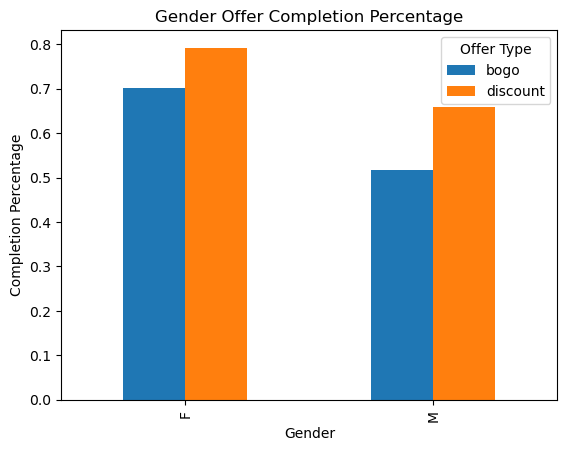

In [43]:
plot_stack (gender_offer_percent,'Gender')

## Q3

In [56]:
income_offer_percent= new_data.groupby(['income_category', 'offer_type'])['complet'].sum()/new_data.groupby(['income_category', 'offer_type'])['complet'].count()
income_offer_percent

income_category  offer_type
High             bogo          0.764995
                 discount      0.840208
Low              bogo          0.398200
                 discount      0.571299
Medium           bogo          0.598048
                 discount      0.717187
Name: complet, dtype: float64

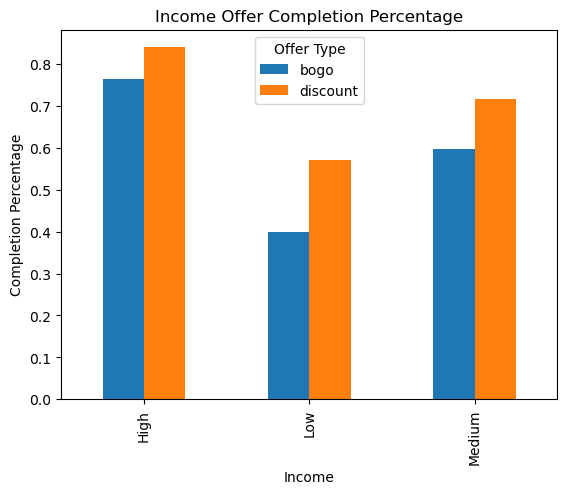

In [44]:
plot_stack (income_offer_percent,'Income')

High income earners benefit from the offers more than low income earners

# Results